In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%M-%d')

In [51]:
# Clean data inladen
freezer = pd.read_csv('freezerdata_clean 15-03 tm 19-03.csv', index_col= 0, sep = ',')
freezer['Date'] = pd.to_datetime(freezer['Date'])
freezer.set_index('Date', inplace= True)
freezer['timeDeltaMins'] = (freezer.index - freezer.index[0]).total_seconds() / 60
freezer['timeDeltaMins'].fillna(0, inplace=True)

freezer = freezer.interpolate(method= 'linear', limit_direction= 'forward', axis= 0)
freezer = freezer.copy()[1:]

C:\Users\chaos\AppData\Local\Temp\ipykernel_2352\2806207593.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





# Plot van de gehele dataset van alle variabelen

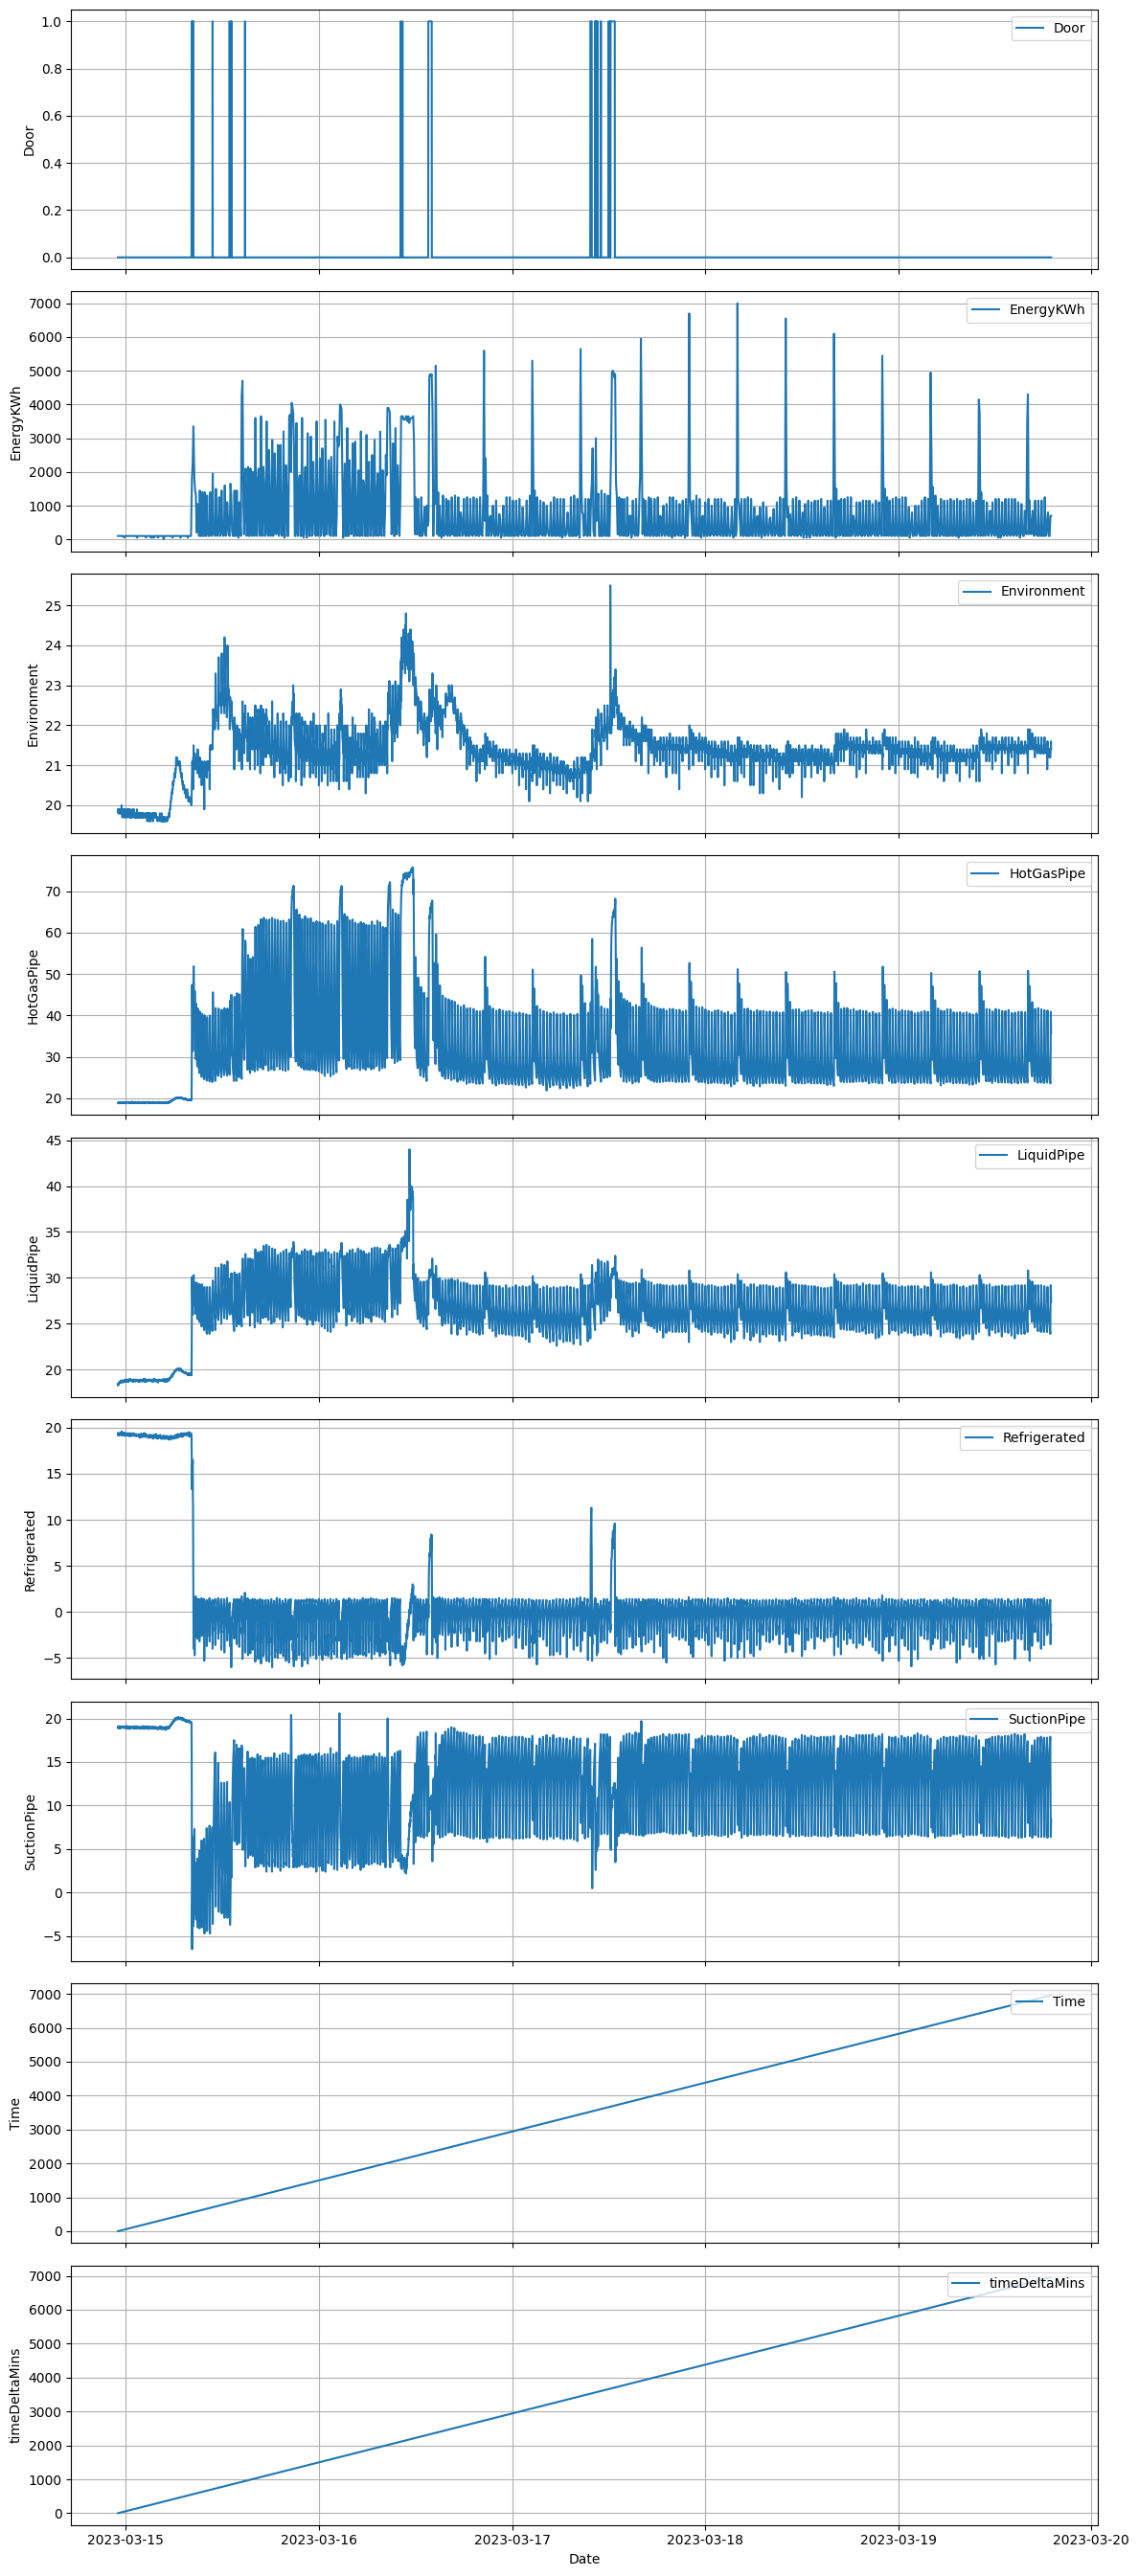

In [10]:
numeric_cols = freezer.select_dtypes(include='number').columns

fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 3 * len(numeric_cols)), sharex=True)

for i, col in enumerate(numeric_cols):
    axes[i].plot(freezer.index, freezer[col], label=col)
    axes[i].set_ylabel(col)
    axes[i].legend(loc='upper right')
    axes[i].grid(True)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


# Plot van de eerste 300 minuten

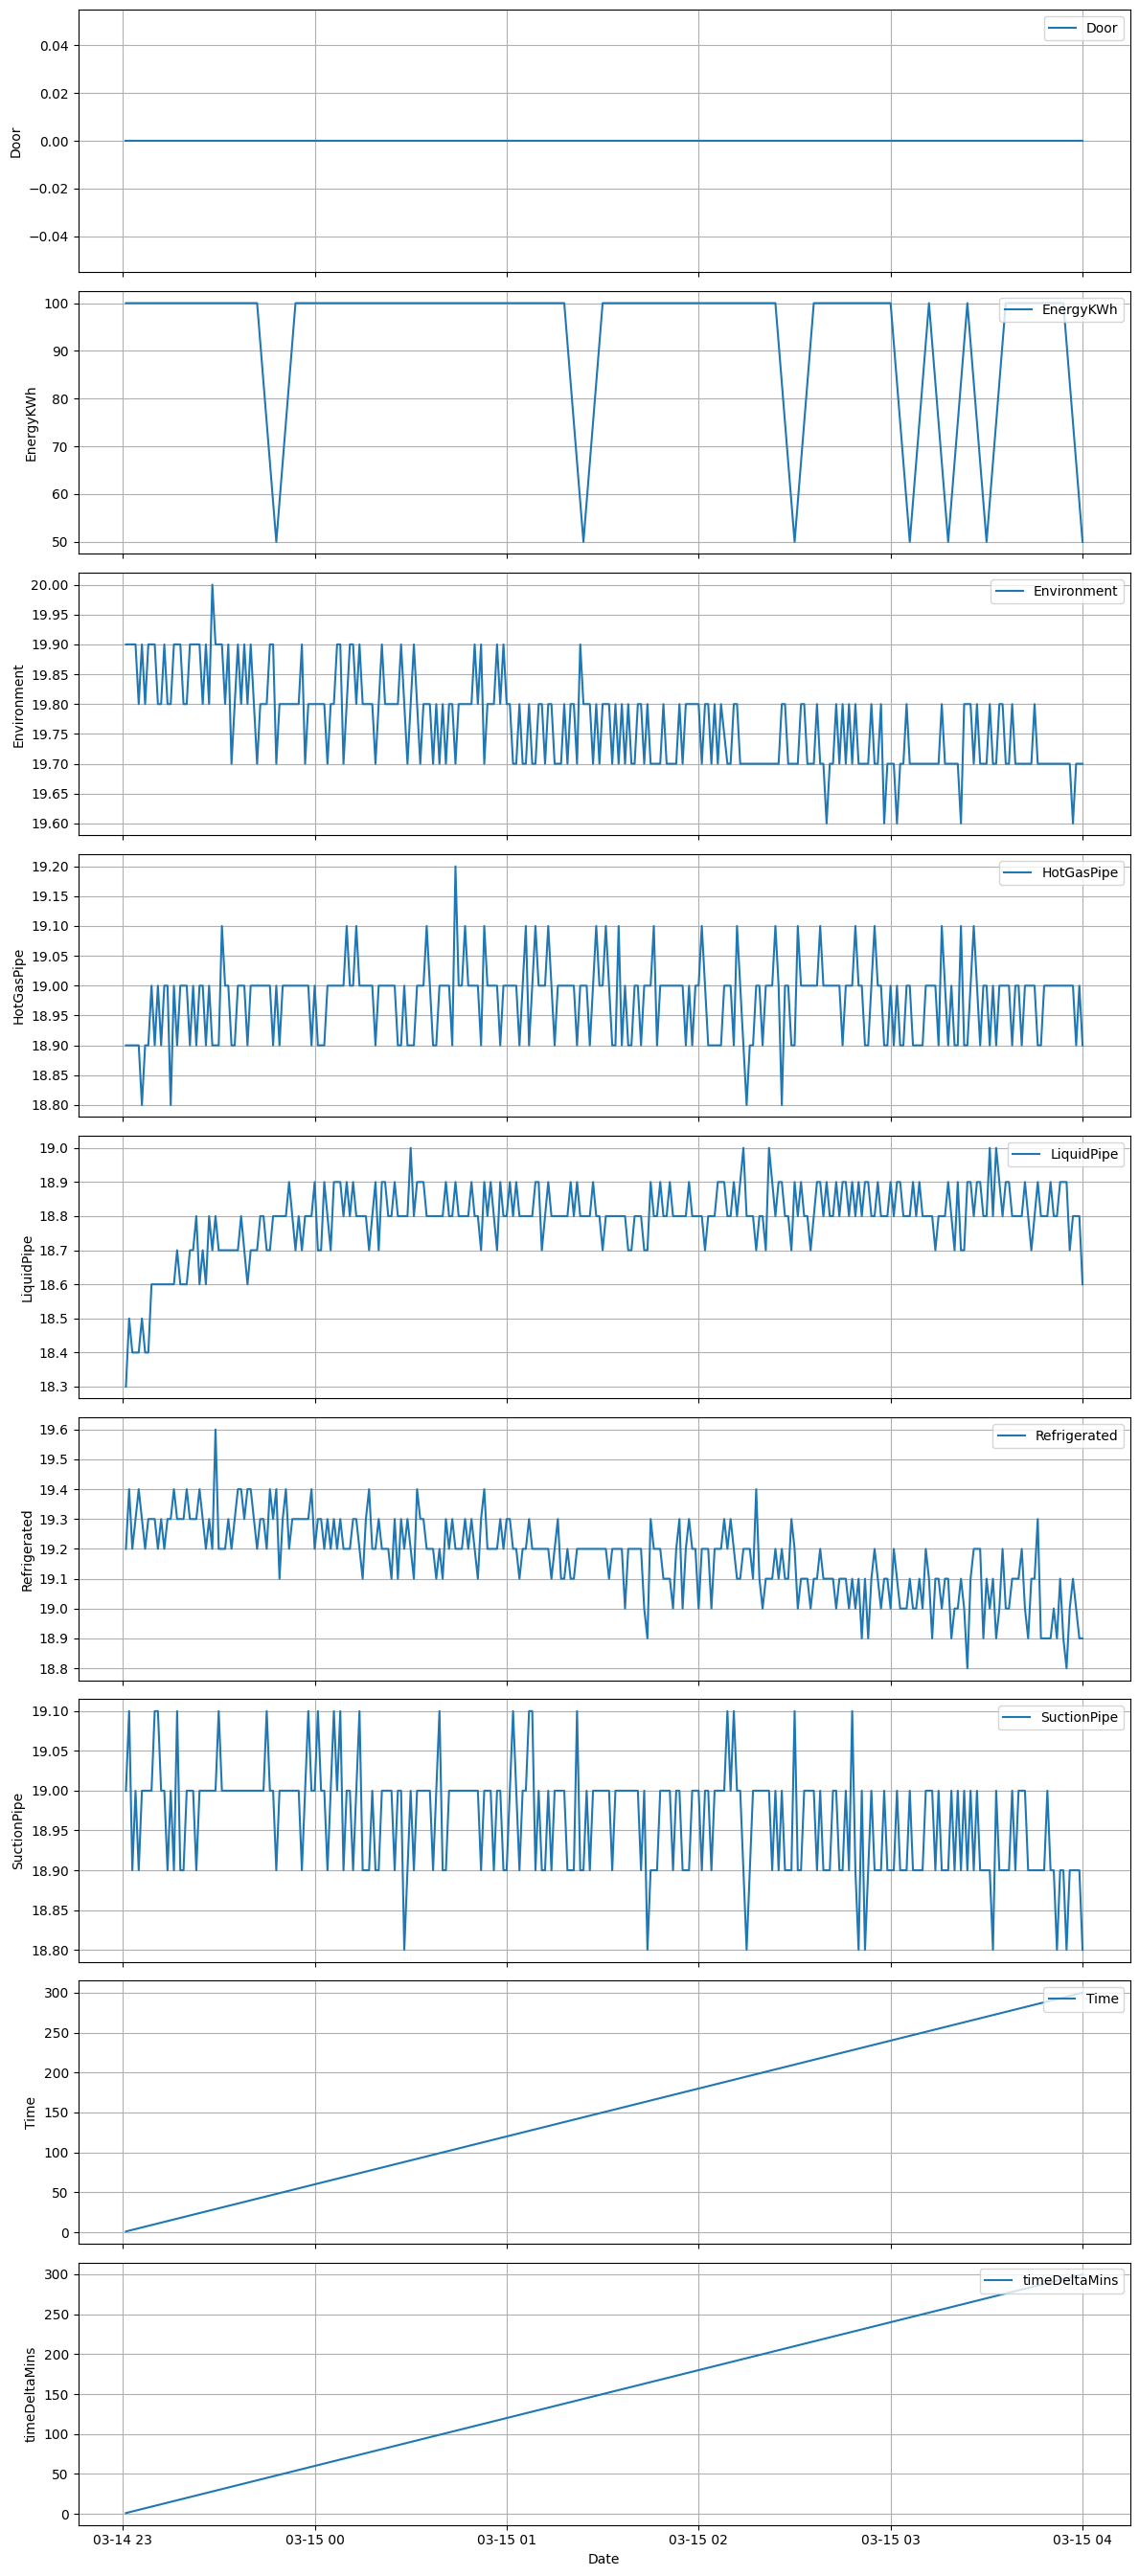

In [12]:
freezer300mins = freezer.loc[freezer['timeDeltaMins'] <= 300]

numeric_cols = freezer300mins.select_dtypes(include='number').columns

fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 3 * len(numeric_cols)), sharex=True)

for i, col in enumerate(numeric_cols):
    axes[i].plot(freezer300mins.index, freezer300mins[col], label=col)
    axes[i].set_ylabel(col)
    axes[i].legend(loc='upper right')
    axes[i].grid(True)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


# Plot met duidelijke scheidslijnen voor elke dag

In [42]:
dates_observation = freezer.index
start_date = np.min(dates_observation)
end_date = np.max(dates_observation)
range(start_date.day, end_date.day)

range(14, 19)

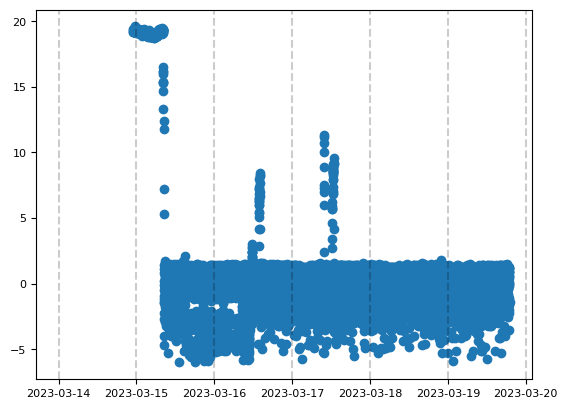

In [60]:
plt.rcParams.update({'font.size': 8})
plt.scatter(freezer.index, freezer['Refrigerated'])
for day in range(start_date.day, end_date.day + 2):
    plt.axvline(pd.to_datetime('2023-03-' + str(day)), color='k', linestyle='--', alpha=0.2)

plt.show()

# Decomposed seasonal plot voor 'Refrigerated'

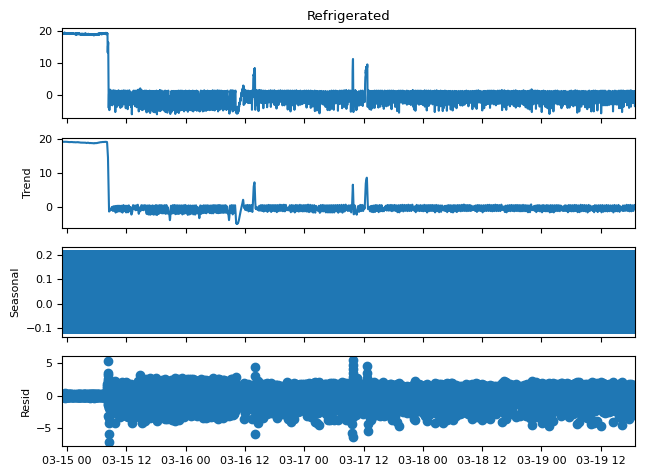

In [61]:
freezer_squeeze =  freezer['Refrigerated'].copy().squeeze()
freezer_squeeze = freezer_squeeze.sort_index(ascending= True).asfreq(pd.infer_freq(freezer_squeeze.index), method= 'ffill')
nresult = seasonal_decompose(freezer_squeeze, model='additive', period=12)
nresult.plot()
plt.show()

# Plot met deviation differences

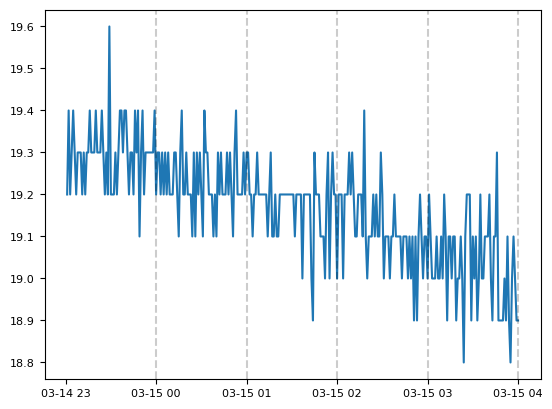

In [78]:
plt.plot(freezer300mins.index, freezer300mins['Refrigerated'])

for ts in freezer300mins.index:
    if ts.minute == 0 and ts.second == 0:
        plt.axvline(ts, color='k', linestyle='--', alpha=0.2)

plt.show()


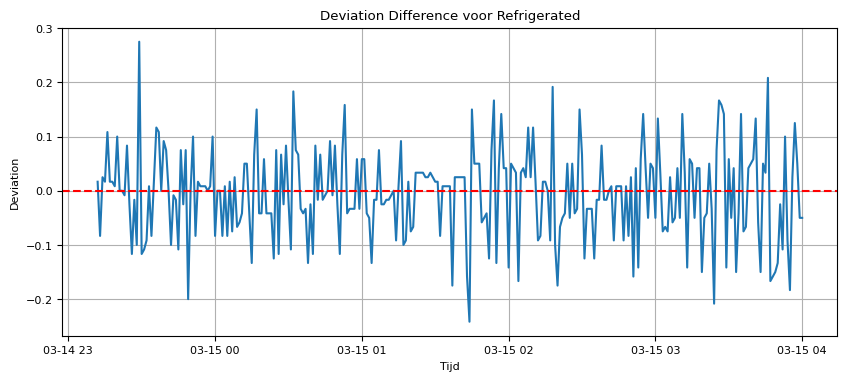

In [87]:
rolling_mean = freezer300mins['Refrigerated'].rolling(window=12).mean()
deviation = freezer300mins['Refrigerated'] - rolling_mean

plt.figure(figsize=(10, 4))
plt.plot(freezer300mins.index, deviation)
plt.axhline(0, color='red', linestyle='--')
plt.title('Deviation Difference voor Refrigerated')
plt.xlabel("Tijd")
plt.ylabel("Deviation")
plt.grid(True)
plt.show()


In [99]:
day_deviations = freezer.groupby(lambda d: d.day).std()

fig = go.Figure()

for col in day_deviations.columns:
    fig.add_trace(go.Scatter(
        x=day_deviations.index,
        y=day_deviations[col],
        mode='lines+markers',
        name=col
    ))


fig.update_layout(
    title='Deviatie per dag voor alle kolommen',
    xaxis_title='Dag',
    yaxis_title='Standaard deviatie',
    legend_title='Kolommen',
    template='plotly_dark',
    height=400,
    width=900
)

fig.show()
